<a href="https://colab.research.google.com/github/fairml-research/SRCVAE/blob/main/SRCVAE_ADULT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline
import sys 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python'))
                  #.loc[lambda df: df['race'].isin(['White', 'Black'])])
    input_data = pd.concat([input_data, pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', names=column_names, na_values="?", sep=r'\s*,\s*', engine='python').loc[1:,:] ])

    input_data[['age','fnlwgt','education_num','capital_gain', 'capital_loss', 'hours_per_week']] = input_data[['age','fnlwgt','education_num','capital_gain', 'capital_loss', 'hours_per_week']].astype(int)
    #input_data = input_data.drop(columns=['hours_per_week'])
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['sex']
    S = (input_data.loc[:, sensitive_attribs]
         .assign(sex=lambda df: (df['sex'] == 'Male').astype(int)))
    # targets; 1 when someone makes over 50k , otherwise 0
    y = input_data['target'].replace({'<=50K.': 0, '>50K.': 1, '>50K': 1, '<=50K': 0 })
    XC = input_data.loc[:, ['country','race','age']]
    #XC = input_data.loc[:, ['age','country','race']]
    XC = XC.assign(race=lambda df: (df['race'] == 'White').astype(int))
    #print(XC.shape)
    XC = (XC
           .fillna('Unknown')
           .pipe(pd.get_dummies, columns = ['country'], drop_first=True))
    # features; note that the 'target' and sentive attribute columns are dropped
    XD = (input_data
         #.drop(columns=['target','age','sex','country'])
         .drop(columns=['target','country','race','age','sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, columns = ['workclass', 'education', 
                    'marital_status', 'occupation', 'relationship'], drop_first=True))
    #X = X.drop(columns=['hours_per_week'])
    print(f"features XD: {XD.shape[0]} samples, {XD.shape[1]} attributes")
    print(f"features XC: {XC.shape[0]} samples, {XC.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives S: {S.shape[0]} samples, {S.shape[1]} attributes")
    return XD, XC, y, S

# load ICU data set
XD, XC, y, S = load_ICU_data('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')

features XD: 48842 samples, 53 attributes
features XC: 48842 samples, 43 attributes
targets y: 48842 samples
sensitives S: 48842 samples, 1 attributes


In [8]:
XC.head()

,race,age,country_Canada,country_China,country_Columbia,country_Cuba,country_Dominican-Republic,country_Ecuador,country_El-Salvador,country_England,...,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Unknown,country_Vietnam,country_Yugoslavia
0,1,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,28,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
XD.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,77516,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,83311,13,0,0,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,215646,9,0,0,40,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,234721,7,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,338409,13,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
# split into train/test set
XD_train, XD_test, XC_train, XC_test, y_train, y_test, S_train, S_test = train_test_split(XD, XC, y, S, test_size=0.2, random_state=7)

# standardize the data
scaler = MinMaxScaler().fit(XD_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

scalerNC = MinMaxScaler().fit(XC_train)
scale_dfNC = lambda df, scalerNC: pd.DataFrame(scalerNC.transform(df), columns=df.columns, index=df.index)

XD_train, XD_test = XD_train.pipe(scale_df, scaler), XD_test.pipe(scale_df, scaler)
XC_train, XC_test = XC_train.pipe(scale_dfNC, scalerNC), XC_test.pipe(scale_dfNC, scalerNC)

XD_train, XD_test, XC_train, XC_test, y_train, y_test = XD_train.values, XD_test.values, XC_train.values, XC_test.values, y_train.values, y_test.values
S_train, S_test =S_train.values, S_test.values
#XC=XC
#x=X

In [11]:
XC_train

array([[1.        , 0.24657534, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.04109589, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.65753425, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.05479452, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.10958904, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.2739726 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

HGR DEPENDENCE ESTIMATION BY NEURAL NETWORK 

In [12]:
dimlatent=5
import torch
import torch.nn as nn
import torch.nn.functional as F
H = 15
H2 = 15

class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(dimlatent, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4

class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(XC.shape[1], H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    

class HGR_NN(nn.Module):
    
    def __init__(self,model_F,model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var,nb):
      
        for j in range(nb) :

            pred_F  = self.mF(yhat.detach())
            pred_G  = self.mG(y2_var.detach())
           
            epsilon=0.0001 
            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
            pred_F_norm[torch.isnan(pred_F_norm )] = 0
            pred_G_norm[torch.isnan(pred_G_norm )] = 0

            ret = torch.mean(pred_F_norm*pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            #print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()
            
        return ret

### STEP 1 - SENSITIVE RECONSTRUCTION

In [13]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
batch_size=128
epochs=10
seed=1
log_interval=10
device = torch.device("cuda")
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #self.fc1NC = nn.Linear(97, 400)  # La dimension de la data est de 94 variables et on rajoute la variable sensible A pour construire l'espace latent U
        #self.fc21NC = nn.Linear(400, 20) # ici c'est pour la moyenne on part sur 20 neurones en deuxiemes couches
        #self.fc22NC = nn.Linear(400, 20) # ici c'est pour les écarts types avec toujours 20 neurones sur la deuxieme couche
 
        self.fc1Z = nn.Linear(XC.shape[1]+XD.shape[1]+1, 400)  # La dimension de la data est de 94 variables et on rajoute la variable sensible A pour construire l'espace latent U
        self.fc21Z = nn.Linear(400, dimlatent) # ici c'est pour la moyenne on part sur 20 neurones en deuxiemes couches
        self.fc22Z = nn.Linear(400, dimlatent) # ici c'est pour les écarts types avec toujours 20 neurones sur la deuxieme couche

        self.fc3D = nn.Linear(XC.shape[1]+dimlatent, 400) # ici c'est la partie decodeur
        self.fc4D = nn.Linear(400, XD.shape[1]) # on revient sur une data sur le nombre de variables de X
        #self.fc42NC = nn.Linear(400, 1) # on prédit uniquement Y => donc une seule colonne

        self.fc3Y = nn.Linear(XC.shape[1]+XD.shape[1]+dimlatent , 400) # ici c'est la partie decodeur
        self.fc41Y = nn.Linear(400, 1) # on revient sur une data sur le nombre de variables de X


    def encodeZ(self, XD, XC, y) :
        h1 = F.relu(self.fc1Z(torch.cat([XC.view(-1, XC.shape[1]),XD.view(-1, XD.shape[1]),y.view(-1, 1)],1)))  # on utilise une simple ReLu pour la premiere couche de 400 neurones et ID pour la deuxieme couche pour u et std
        return self.fc21Z(h1), self.fc22Z(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # racine de la variance ==> std
        eps = torch.randn_like(std)   # une loi normal entre 0 et 1 avec une taille de std soit de 20 !!
        #eps =1
        return mu + eps*std  # z = u + sigm * eps

    def decodeXD(self,  XD, XC, y, Z):
        h3 = F.relu(self.fc3D(torch.cat([XC.view(-1, XC.shape[1]),Z],1))) # la 3eme couche et donc la premiere couche du decoder a une relu avec 400 neurones 
        return torch.sigmoid(self.fc4D(h3))#, torch.sigmoid(self.fc42NC(h3)) # la 4 eme couche et dernier on souhaite retrouver une data on met une sigmoid car on a quelque chose entre . et 1

    def decodeY(self,  XD, XC, y, Z):
        #print(torch.cat([XC.view(-1, 43),Xdrec.view(-1, 53), S],1).shape)
        h3 = F.relu(self.fc3Y(torch.cat([XC.view(-1, XC.shape[1]),XD.view(-1, XD.shape[1]), Z],1))) # la 3eme couche et donc la premiere couche du decoder a une relu avec 400 neurones 
        return torch.sigmoid(self.fc41Y(h3)) # la 4 eme couche et dernier on souhaite retrouver une data on met une sigmoid car on a quelque chose entre . et 1

    def forward(self, XD, XC, y):
        muZ, logvarZ = self.encodeZ(XD, XC, y)  # on recupere le X et on obtient le u et la logvar qui va nous servir à calculer z en reparameterize trick
        Z = self.reparameterize(muZ, logvarZ) # en deuxieme couche une fois qu on recupere u et sigma on utilise une loi normal entre 0 et 1 u + sigmaµ eps
        recon_XD_batch = self.decodeXD(XD, XC, y, Z)
        recon_Y_batch = self.decodeY(XD, XC, y,  Z)

        #mu1, logvar1 = self.encode(x.view(-1, 94), a)  # on recupere le X et on obtient le u et la logvar qui va nous servir à calculer z en reparameterize trick
        #z1 = self.reparameterize(mu1, logvar1) # en deuxieme couche une fois qu on recupere u et sigma on utilise une loi normal entre 0 et 1 u + sigmaµ eps
        #mu0, logvar0 = self.encode(x.view(-1, 94), a)  # on recupere le X et on obtient le u et la logvar qui va nous servir à calculer z en reparameterize trick
        #z0 = self.reparameterize(mu0, logvar0) # en deuxieme couche une fois qu on recupere u et sigma on utilise une loi normal entre 0 et 1 u + sigmaµ eps
        return  recon_XD_batch, Z, recon_Y_batch, muZ, logvarZ # on decode ici pour retrouver une image ici


class Demographic(nn.Module):
    def __init__(self):
        super(Adversarial, self).__init__()
        self.adv_fc1 = nn.Linear(44, 6)
        self.adv_fc2 = nn.Linear(6, 2)
        self.adv_fc3 = nn.Linear(2, 1)

    def forward(self, x):
        x = self.adv_fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc2(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc3(x)
        x = F.sigmoid(x)
        return x

class Adversarial(nn.Module):
    def __init__(self):
        super(Adversarial, self).__init__()
        self.adv_fc1 = nn.Linear(20, 6)
        self.adv_fc2 = nn.Linear(6, 2)
        self.adv_fc3 = nn.Linear(2, 2)

    def forward(self, x):
        x = self.adv_fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc2(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.8)
        x = self.adv_fc3(x)
        x = F.relu(x)
        return x
   
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    tiled_x = x.unsqueeze(1).repeat(1, y_size, 1)
    tiled_y = y.unsqueeze(0).repeat(x_size, 1, 1)
    #print('x', x)
    #print('x', y)
    #print('xshape', x.shape)
    #print('yshapbinary_cross_entropy', y.shape)
    #print('tiled_x',tiled_x)
    #print('tiled_y',tiled_y)
    return ((-(tiled_x - tiled_y) ** 2).mean(dim=2) / float(dim)).exp_()

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd


In [14]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from sklearn.utils import shuffle
from torch.autograd import Variable

latent_dim=5
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

mF = Net_HGR().cuda()
mG = Net2_HGR().cuda()
optimizer_F = optim.Adam(mF.parameters(), lr=1e-4)
optimizer_G = optim.Adam(mG.parameters(), lr=1e-4)
epsilon=0.0001

betaX = 1.5
betaY = betaX
betammd = 0.1
betahgr = 0.15 #15#0.5

batch_idx=0
batch_size=2048 #512
epochs=150
epochs_hgr=50
epoch_startHGR = 30
seed=1
log_interval=1

batch_no = len(XD_train) // batch_size

for epoch in range(epochs):

  XDtrain, XCtrain, ytrain = shuffle(XD_train, XC_train , np.expand_dims(y_train,axis = 1))
  
  average_total_loss = 0
  average_lossX = 0
  average_mmd = 0
  average_lossY = 0
  average_mmdZ = 0
  average_hgr = 0
  betahgr2=betahgr
  # Mini batch learning  
  for i in range(batch_no):
    
    start = i * batch_size
    end = start + batch_size
    x_varD = Variable(torch.FloatTensor(XDtrain[start:end])).cuda()
    x_varC = Variable(torch.FloatTensor(XCtrain[start:end])).cuda()
    y_var = Variable(torch.FloatTensor(ytrain[start:end])).cuda()
    recon_xD, Z, recon_y, mu, logvar = model(x_varD, x_varC, y_var)
    
    #if (epoch ==10) & (i<5) :
    #  for k in range(400) :
    #    optimizer_F.zero_grad()
    #    optimizer_G.zero_grad()
    #    
    #    pred_F  = mF(s_var.detach())
    #    pred_G  = mG(z.view(-1, latent_dim).detach())
    #    pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
    #    pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

    #    ret = torch.mean(pred_F_norm*pred_G_norm)
    #    loss_HGR = - ret  # maximize
    #    loss_HGR.backward()

    #    optimizer_F.step()
    #    optimizer_G.step()

    if epoch > epoch_startHGR :
      betahgr2=betahgr
      for k in range(epochs_hgr):
        
        optimizer_F.zero_grad()
        optimizer_G.zero_grad()
        
        pred_F  = mF(Z.detach().cuda())
        pred_G  = mG(x_varC.detach().cuda()) #,x_var.detach().cuda(),y_var.detach().cuda()],1))
        pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
        pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

        ret = torch.mean(pred_F_norm*pred_G_norm)
        loss_HGR = - ret  # maximize
        loss_HGR.backward()

        optimizer_F.step()
        optimizer_G.step()


    optimizer.zero_grad()
    recon_XD, Z, recon_y, mu, logvar = model(x_varD, x_varC, y_var)
    lossX = F.binary_cross_entropy(recon_XD, x_varD.view(-1, x_varD.shape[1]), reduction='mean')
    lossY = F.binary_cross_entropy(recon_y, y_var.view(-1, 1), reduction='mean')

    #lossXC = F.binary_cross_entropy(recon_XC, x_varC.view(-1, 43), reduction='mean')

    true_samplesZ = Variable(
               torch.randn(x_varD.shape[0], 1),
                requires_grad=False
            ).to(device)
    mmdZ = compute_mmd(true_samplesZ, Z)

    #mmd =0
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    ### Training the adversary for epochs_adv epochs
    
    pred_F  = mF(Z)
    pred_G  = mG(x_varC)
    pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
    pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
    ret = torch.mean(pred_F_norm*pred_G_norm)
    loss = betaX*lossX + betaY*lossY + betammd*mmdZ  + betahgr2*ret  ## WITHOUT THE HGR PENALIZATION (THE FIRST EPOCHS)

    #if epoch > epoch_startHGR :
    #  loss = betaX*lossX + betaY*lossY + betammd*mmdZ + betahgr2*ret  ## WITH THE HGR PENALIZATION

    loss.backward()
    optimizer.step()

    ## Average losses on the whole data
    average_total_loss += loss.item()
    average_lossX += lossX.item()
    average_lossY += lossY.item()
    average_mmdZ += mmdZ.item()
    average_hgr += ret.item()

  if epoch % log_interval == 0:
    print('====> Epoch: {} Total loss: {:.4f} || Loss X: {:.4f} || Loss Y: {:.4f} || MMD: {:.4f} || HGR: {:.4f} '.format(epoch, average_total_loss / batch_no, average_lossX / batch_no, average_lossY/ batch_no, average_mmd / batch_no, average_hgr / batch_no ))#,'MSE :', np.mean((y_train - recon_Y_batch.detach().numpy())**2))


====> Epoch: 0 Total loss: 1.7262 || Loss X: 0.5330 || Loss Y: 0.5755 || MMD: 0.0000 || HGR: -0.0070 
====> Epoch: 1 Total loss: 1.1479 || Loss X: 0.2795 || Loss Y: 0.4380 || MMD: 0.0000 || HGR: -0.0141 
====> Epoch: 2 Total loss: 0.8442 || Loss X: 0.2474 || Loss Y: 0.2727 || MMD: 0.0000 || HGR: -0.0267 
====> Epoch: 3 Total loss: 0.5248 || Loss X: 0.2309 || Loss Y: 0.0725 || MMD: 0.0000 || HGR: -0.0482 
====> Epoch: 4 Total loss: 0.4115 || Loss X: 0.2272 || Loss Y: 0.0060 || MMD: 0.0000 || HGR: -0.0722 
====> Epoch: 5 Total loss: 0.3822 || Loss X: 0.2166 || Loss Y: 0.0033 || MMD: 0.0000 || HGR: -0.0885 
====> Epoch: 6 Total loss: 0.3652 || Loss X: 0.2095 || Loss Y: 0.0026 || MMD: 0.0000 || HGR: -0.0916 
====> Epoch: 7 Total loss: 0.3499 || Loss X: 0.2020 || Loss Y: 0.0019 || MMD: 0.0000 || HGR: -0.0879 
====> Epoch: 8 Total loss: 0.3332 || Loss X: 0.1927 || Loss Y: 0.0013 || MMD: 0.0000 || HGR: -0.0845 
====> Epoch: 9 Total loss: 0.3151 || Loss X: 0.1821 || Loss Y: 0.0011 || MMD: 0.00

In [15]:
######### In case you want to save the inference model :

#torch.save(model.state_dict(), "WithoutDemographic_adult5_S8" + str(betahgr),_use_new_zipfile_serialization=False)

In [16]:
######### In case you want to load the inference model :

#model_VAE = VAE().to(device)
#model_VAE.load_state_dict(torch.load("WithoutDemographic_adult5_5_0"))
#model = model_VAE

### STEP 2: UNWANTED BIASES MITIGATION BASED ON THE Z PROXY (from step 1) 


In [17]:

import torch
import torch.nn as nn
import torch.nn.functional as F
H = 15
H2 = 15
epochs_hgr=50

class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(dimlatent, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


model_Net_F = Net_HGR()
model_Net_G = Net2_HGR()

class HGR_NN(nn.Module):
    
    def __init__(self,model_F,model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_Net_F
        self.mG = model_Net_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var,nb):
      
        for j in range(nb) :
            #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
            #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))

            yhat2  =yhat.data.numpy()
            y2_var2=y2_var.data.numpy()
        
            yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
            y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)

            pred_F  = self.mF(yhat2_PT)
            pred_G  = self.mG(y2_var_PT)

            #epsilon=0.0000000000000000001
            epsilon=0.0001 
            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
            pred_F_norm[torch.isnan(pred_F_norm )] = 0
            pred_G_norm[torch.isnan(pred_G_norm )] = 0

            ret = torch.mean(pred_F_norm*pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            #print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret.data.numpy()


mF = Net_HGR().cuda()
mG = Net2_HGR().cuda()
optimizer_F = optim.Adam(mF.parameters(), lr=1e-4)
optimizer_G = optim.Adam(mG.parameters(), lr=1e-4)
epsilon=0.0001

batch_size = 512
num_epochs = 20
learning_rate = 0.0001
batch_no = len(XD_train) // batch_size
#XD_train_inv = recon_X_batch_a.data.numpy()
#Y_train_inv = recon_Y_batch_a.data.numpy()

from sklearn.utils import shuffle
from torch.autograd import Variable
criterionMSE = nn.MSELoss()
import math
nb_a=200
from torch.nn import functional as F
def sigmoid(x):
  output = [1 / (1 + math.exp(-x)) for x in x]
  return output

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(XD.shape[1]+XC.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x


model_Y = NN().cuda()
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer_Y = torch.optim.Adam(model_Y.parameters(), lr=0.001)
criterion_ADV =  nn.MSELoss()
#A0 = sensitive.mean() + sensitive.std()*Variable(torch.randn(data.shape[0]*nb_a, 1),requires_grad=False)
#recon_X_batch_a0, z_a0, recon_Y_batch_a0, mu_a0, logvar_a0 = model(data.repeat(nb_a,1).view(-1, 33),A0)
#recon_x, recon_XC, S, U,  recon_y, mu, logvar = model(x_var, x_varC, y_var,s_var)
from sklearn.metrics import accuracy_score
XD_trainCUDA = Variable(torch.FloatTensor(XD_train)).cuda()
XC_trainCUDA = Variable(torch.FloatTensor(XC_train)).cuda()
y_trainCUDA = Variable(torch.FloatTensor(np.expand_dims(y_train,axis = 1))).cuda()

XD_testCUDA = Variable(torch.FloatTensor(XD_test)).cuda()
XC_testCUDA = Variable(torch.FloatTensor(XC_test)).cuda()
y_testCUDA = Variable(torch.FloatTensor(np.expand_dims(y_test,axis = 1))).cuda()
table = [0,0,0,0,0,0]
for epoch in range(num_epochs):
    #if epoch % 50 != 0:
        #XD_train = Variable(torch.FloatTensor(XD_train.values),requires_grad=True)
        #XD_test = Variable(torch.FloatTensor(XD_test.values),requires_grad=True)
        #print('Epoch {}'.format(epoch+1))
        
        #y_predX= model(XD_train).data.numpy().T
        #y_predXinv= model(recon_X_batch_a0).data.numpy().T

        #accuracy = (y_train-np.squeeze(y_predX)).pow(2).sum()     
        #accuracycount = accuracy_score(Y_train_inv.squeeze(1), np.squeeze(y_predXinv))
        #print ("Train Accuracy:", accuracy)#,"Train Accuracy Count:", accuracycount, "CLP:", np.mean(logit_y_predX-logit_y_predXinv)**2)
    XDtrain, XCtrain, ytrain, sens_train = shuffle(XD_train, XC_train, np.expand_dims(y_train,axis = 1),  S_train)

    #A = s_var.mean() + s_var.std()*Variable(torch.randn(batch_size*nb_a, 1),requires_grad=False)
    # Mini batch learning
    for i in range(batch_no):
        print('Epoch: ', epoch, 'Batch:',i)
        start = i * batch_size
        end = start + batch_size

        x_var = Variable(torch.FloatTensor(XDtrain[start:end])).cuda()
        XC_var = Variable(torch.FloatTensor(XCtrain[start:end])).cuda()
        y_var = Variable(torch.FloatTensor(ytrain[start:end])).cuda()
        s_var = Variable(torch.FloatTensor(sens_train[start:end])).cuda()

        #recon_X_batch_a, z_a, recon_Y_batch_a, mu_a, logvar_a = model(x_var.repeat(nb_a,1).view(-1, 53),x_var.repeat(nb_a,1).view(-1, 33))
        recon_x, Z, recon_y, mu, logvar = model(x_var.repeat(nb_a,1).view(-1, x_var.shape[1]), XC_var.repeat(nb_a,1).view(-1, XC_var.shape[1]), y_var.repeat(nb_a,1).view(-1, 1))

        #ypredcontworld = model_Y(torch.cat([recon_XC.view(-1, 43),recon_x.view(-1, 53)],1))
        #ypredcontworld = model_Y(torch.cat([x_var.view(-1, x_var.shape[1]),XC_var.view(-1, XC.shape[1])],1))
        #lossX_inv = criterion(ypredcontworld, y_var)
        #ypred2= ypredcontworld.detach()

        if epoch ==0:
          for l in range(10):
            ypred_var = model_Y(torch.cat([XC_var.view(-1, XC.shape[1]),x_var.view(-1, x_var.shape[1])],1))
            lossY =criterion(ypred_var, y_var)
            loss = lossY #+betamse*ret # + lossX_inv -2*lossX#+ betamse*MSEcount
            print('loss tot', loss, 'loss Y', lossY)
            loss.backward()
            optimizer_Y.step()
        #S=s_var.repeat(nb_a,1).view(-1, 1)
        ypred_var2 = model_Y(torch.cat([XC_var.repeat(nb_a,1).view(-1, XC.shape[1]),x_var.repeat(nb_a,1).view(-1, x_var.shape[1])],1))

        for k in range(epochs_hgr):
          
          optimizer_F.zero_grad()
          optimizer_G.zero_grad()
          
          pred_F  = mF(Z.detach().cuda())
          pred_G  = mG(ypred_var2.detach().cuda())
          pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
          pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

          ret = torch.mean(pred_F_norm*pred_G_norm)
          loss_HGR = - ret  # maximize
          loss_HGR.backward()

          optimizer_F.step()
          optimizer_G.step()
        #Yhat_count =  Variable(torch.FloatTensor(ypred_var.data.numpy().T.repeat(nb_a,1).T))
        #MSEcount = (Yhat_count-ypredcontworld).pow(2).sum() 
        
        optimizer_Y.zero_grad()
        ypred_var = model_Y(torch.cat([XC_var.view(-1, XC.shape[1]),x_var.view(-1, x_var.shape[1])],1))
        ypred_var2 = model_Y(torch.cat([XC_var.repeat(nb_a,1).view(-1, XC.shape[1]),x_var.repeat(nb_a,1).view(-1, x_var.shape[1])],1))
        lossY =criterion(ypred_var, y_var)
        betaDP =0.46 #.5#44 #7   ## LAMBDA =0.7
        pred_F  = mF(Z)
        pred_G  = mG(ypred_var2)
        pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
        pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))

        ret = torch.mean(pred_F_norm*pred_G_norm)
        loss = lossY +betaDP*ret # + lossX_inv -2*lossX#+ betamse*MSEcount

        if epoch ==0:
          loss = lossY  # + lossX_inv -2*lossX#+ betamse*MSEcount
        print('loss tot', loss, 'loss Y', lossY)
        print('HGR', ret)

        loss.backward()
        optimizer_Y.step()
        Ypred = torch.sigmoid(model_Y(torch.cat([XC_trainCUDA.view(-1, XC.shape[1]),XD_trainCUDA.view(-1, x_var.shape[1])],1)))>0.5
        Ho = (S_train==1)
        Fe = (S_train==0)
        odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
        PRULE= min(odds, 1/odds)

        Ypredtest = torch.sigmoid(model_Y(torch.cat([XC_testCUDA.view(-1, XC.shape[1]),XD_testCUDA.view(-1, x_var.shape[1])],1)))>0.5
        Ho = (S_test==1)
        Fe = (S_test==0)
        odds=Ypredtest.float()[Ho].mean()/ Ypredtest.float()[Fe].mean()
        PRULEtest= min(odds, 1/odds)
        print('ACC Train',(Ypred==y_trainCUDA).sum()/XD_train.shape[0], 'PRULE',PRULE, 'ACC Test',(Ypredtest==y_testCUDA).sum()/XD_test.shape[0],'PRULEtest',PRULEtest)
        table = np.vstack([table,[(Ypred.cpu().data.numpy()==y_trainCUDA.cpu().data.numpy()).sum()/XD_train.shape[0]*100,PRULE.cpu().data.numpy(),ret.cpu().data.numpy(), 
                                  (Ypredtest.cpu().data.numpy()==y_testCUDA.cpu().data.numpy()).sum()/XD_test.shape[0]*100,PRULEtest.cpu().data.numpy(),ret.cpu().data.numpy()]])

np.savetxt(sys.stdout, np.mean(table[1:,], axis=0).astype(float), '%5.2f')


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
loss tot tensor(0.6745, device='cuda:0', grad_fn=<AddBackward0>) loss Y tensor(0.3724, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
HGR tensor(0.6567, device='cuda:0', grad_fn=<MeanBackward0>)
ACC Train tensor(0.8136, device='cuda:0') PRULE tensor(0.3796, device='cuda:0') ACC Test tensor(0.8023, device='cuda:0') PRULEtest tensor(0.3567, device='cuda:0')
Epoch:  6 Batch: 66
loss tot tensor(0.6866, device='cuda:0', grad_fn=<AddBackward0>) loss Y tensor(0.4000, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
HGR tensor(0.6232, device='cuda:0', grad_fn=<MeanBackward0>)
ACC Train tensor(0.8136, device='cuda:0') PRULE tensor(0.3822, device='cuda:0') ACC Test tensor(0.8018, device='cuda:0') PRULEtest tensor(0.3578, device='cuda:0')
Epoch:  6 Batch: 67
loss tot tensor(0.6671, device='cuda:0', grad_fn=<AddBackward0>) loss Y tensor(0.3786, device='cuda:0',
       gra

In [18]:
Ypred = torch.sigmoid(model_Y(torch.cat([XC_trainCUDA.view(-1, XC.shape[1]),XD_trainCUDA.view(-1, XD_trainCUDA.shape[1])],1)))>0.5
Ho = (S_train==1)
Fe = (S_train==0)
odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
PRULE= min(odds, 1/odds)
print('Prule Train: ', PRULE)

Prule Train:  tensor(0.6733, device='cuda:0')


In [19]:
%matplotlib inline

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)

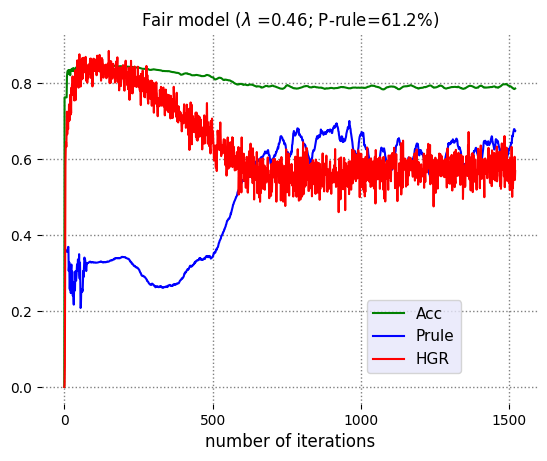

In [21]:

filter  = 0
iter = range(table[filter:].shape[0])
ACC = table[:,0]
PRULE = table[:,1]
HGR = table[:,2]

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.plot(iter, ACC/100, color = 'green',label="Acc")
ax1.plot(iter, PRULE, color = 'blue',label="Prule")
ax1.plot(iter, HGR, color = 'red',label="HGR")
#leg = plt.legend(loc="best", edgecolor="gray",facecolor="gray")
#plt.ylim(0,25)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.xlabel("number of iterations", fontsize=12)
#plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.3),shadow=False, ncol=1, fontsize=11,facecolor='lavender')
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betaDP) + '; P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Trainingcurves_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf()


<Figure size 600x600 with 0 Axes>

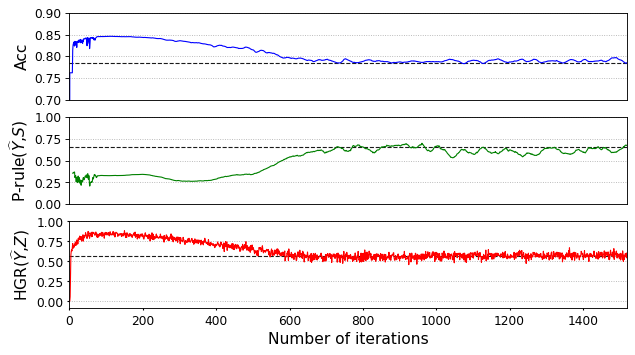

In [22]:
    import matplotlib.pyplot as plt 
    plt.rcdefaults()    
    import matplotlib.ticker as ticker
    from matplotlib.pyplot import figure
    figure(figsize=(9, 4.8), dpi=80)
    import matplotlib.pyplot as plt
    ax1 = plt.subplot(311)  
    values = np.array(ACC/100)
    plt.plot(range(len(values)), values, color="blue",linewidth=1, markersize=12)
    plt.grid(True)  
    ax1.spines.linewidth=0
    min_Lf=np.mean(values[-2:])
    n_iter=ACC.shape[0]
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed",linewidth=1)
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(0.7, 0.9)
    plt.xticks([])
    plt.xlim(0, n_iter)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    plt.grid(True, linestyle='dotted')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.ylabel(r"Acc", fontsize=14)
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = PRULE 
    plt.plot(range(len(values)), values, color="green",linewidth=1, markersize=12)  
    min_Lf=np.mean(values[-20:])
    n_iter=ACC.shape[0]
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed",linewidth=1)
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(0, 1)
    plt.xticks([])
    plt.xlim(0, n_iter)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    plt.grid(True, linestyle='dotted')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylabel(r"P-rule($\widehat{Y}$,$S$)", fontsize=14)
    #plt.ylabel(r"P-rule", fontsize=10)
    
    ax3 = plt.subplot(313)
    values = np.array(HGR)
    plt.plot(range(len(values)), values, color="red",linewidth=1, markersize=12)  
    min_Lf=np.mean(values[-10:])
    n_iter=ACC.shape[0]
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed",linewidth=1)
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #low = low + (high-low) * 0.5
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, 1)
    plt.xlim(0, n_iter)
    ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    plt.grid(axis="y", linestyle='dotted')
    plt.ylabel("HGR($\widehat{Y}$,$Z$)", fontsize=14)
    #plt.ylabel("HGR", fontsize=10)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel("Number of iterations", fontsize=14)
    ax3.tick_params(direction='out', length=2, width=1,
                grid_alpha=1)
plt.rcParams["font.size"] = 10
plt.savefig("Trainingcurves_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
plt.show()
#plt.savefig("/content/drive/MyDrive/Withoutdemo/Trainingcurves_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')


tensor(0.6125, device='cuda:0')


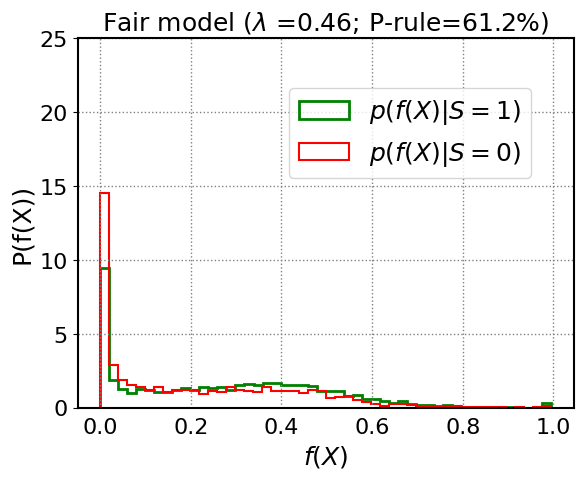

In [23]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


Ypredtest = torch.sigmoid(model_Y(torch.cat([XC_testCUDA.view(-1, XC_testCUDA.shape[1]),XD_testCUDA.view(-1, XD_testCUDA.shape[1])],1)))>0.5
Ho = (S_test==1)
Fe = (S_test==0)
odds=Ypredtest.float()[Ho].mean()/ Ypredtest.float()[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest = torch.sigmoid(model_Y(torch.cat([XC_testCUDA.view(-1, XC_testCUDA.shape[1]),XD_testCUDA.view(-1, XD_testCUDA.shape[1])],1)))
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)

fig, ax1 = plt.subplots(linewidth=20.5)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
ax1.tick_params( axis='both', bottom = False, top = False)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$",linewidth=2)
ax1.hist(Ypredtest.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,25)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=18)
plt.ylabel("P(f(X))", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.67, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betaDP) + '; P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
#fig.savefig("/content/drive/MyDrive/Withoutdemo/Test_distrib_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 



tensor(0.6125, device='cuda:0')


<Figure size 600x600 with 0 Axes>

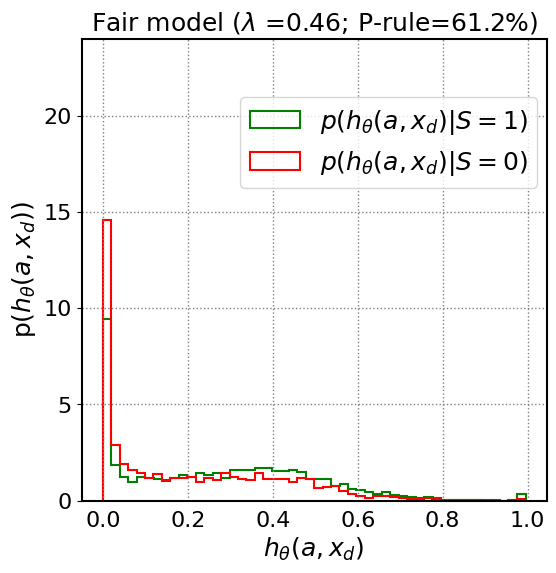

In [26]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
Ypredtest = torch.sigmoid(model_Y(torch.cat([XC_testCUDA.view(-1, 43),XD_testCUDA.view(-1, 53)],1)))>0.5
Ho = (S_test==1)
Fe = (S_test==0)
odds=Ypredtest.float()[Ho].mean()/ Ypredtest.float()[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest = torch.sigmoid(model_Y(torch.cat([XC_testCUDA.view(-1, 43),XD_testCUDA.view(-1, 53)],1)))
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])

ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,24)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(a,x_{d})$", fontsize=18)
plt.ylabel("p($h_{\\theta}(a,x_{d})$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betaDP) + '; P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
#fig.savefig("/content/drive/MyDrive/Withoutdemo/Test_distrib_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 

tensor(0.6125, device='cuda:0')


<Figure size 600x600 with 0 Axes>

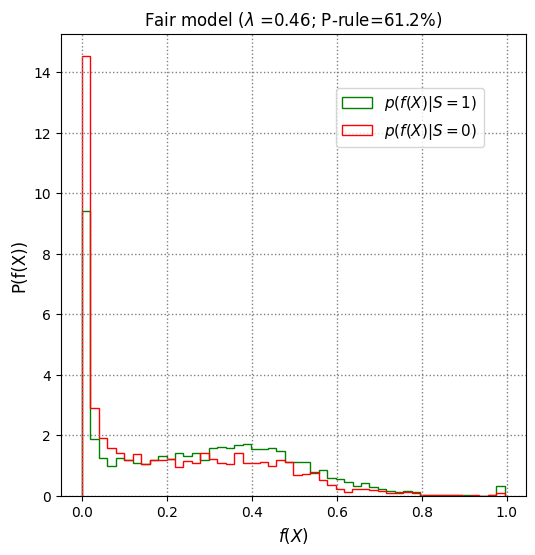

In [27]:

Ypredtest = torch.sigmoid(model_Y(torch.cat([XC_testCUDA.view(-1, XC_testCUDA.shape[1]),XD_testCUDA.view(-1, XD_testCUDA.shape[1])],1)))>0.5
Ho = (S_test==1)
Fe = (S_test==0)
odds=Ypredtest.float()[Ho].mean()/ Ypredtest.float()[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest = torch.sigmoid(model_Y(torch.cat([XC_testCUDA.view(-1, XC_testCUDA.shape[1]),XD_testCUDA.view(-1, XD_testCUDA.shape[1])],1)))

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.hist(Ypredtest.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(Ypredtest.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
#plt.ylim(0,25)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=12)
plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.9),shadow=False, ncol=1, fontsize=11)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betaDP) + '; P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Test_distrib_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')
#fig.savefig("/content/drive/MyDrive/Withoutdemo/Test_distrib_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULEtest.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 


In [28]:
Ypred = torch.sigmoid(model_Y(torch.cat([XC_trainCUDA.view(-1, XC_trainCUDA.shape[1]),XD_trainCUDA.view(-1, XD_trainCUDA.shape[1])],1)))>0.5
Ho = (S_train==1)
Fe = (S_train==0)
odds=Ypred.float()[Ho].mean()/ Ypred.float()[Fe].mean()
PRULE= min(odds, 1/odds)
print('Prule Train: ', PRULE)

Prule Train:  tensor(0.6733, device='cuda:0')


<Figure size 600x600 with 0 Axes>

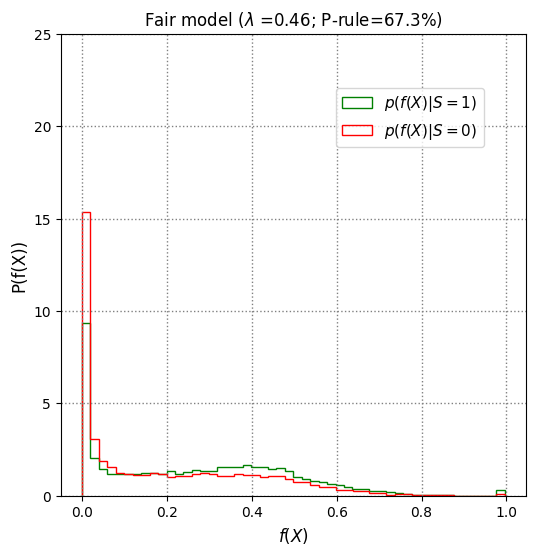

In [29]:
Ypred = torch.sigmoid(model_Y(torch.cat([XC_trainCUDA.view(-1, XC_trainCUDA.shape[1]),XD_trainCUDA.view(-1, XD_trainCUDA.shape[1])],1)))
Ho = (S_train==1)
Fe = (S_train==0)
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.hist(Ypred.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(Ypred.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best", edgecolor="gray",facecolor="gray")
plt.ylim(0,25)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=12)
plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.9),shadow=False, ncol=1, fontsize=11)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betaDP) + '; P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Train_distrib25_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')
#fig.savefig("/content/drive/MyDrive/Withoutdemo/Train_distrib_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')

plt.show()
plt.clf() 

<Figure size 600x600 with 0 Axes>

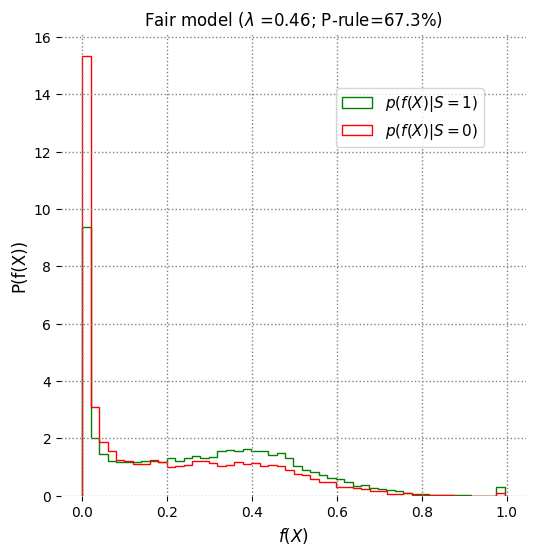

In [30]:
PRULEYpred = torch.sigmoid(model_Y(torch.cat([XC_trainCUDA.view(-1, XC_trainCUDA.shape[1]),XD_trainCUDA.view(-1, XD_trainCUDA.shape[1])],1)))
Ho = (S_train==1)
Fe = (S_train==0)
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.hist(Ypred.float()[Ho].cpu().data.numpy(), color = 'green',bins=50, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(Ypred.float()[Fe].cpu().data.numpy(), color = 'red',bins=50, density=1,histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best", edgecolor="gray",facecolor="gray")
#plt.ylim(0,25)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.xlabel("$f(X)$", fontsize=12)
plt.ylabel("P(f(X))", fontsize=12)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.9),shadow=False, ncol=1, fontsize=11)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(betaDP) + '; P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) +'%)', fontsize=12)
fig.savefig("Train_distrib_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')
#fig.savefig("/content/drive/MyDrive/Withoutdemo/Train_distrib_lam" + str(betaDP)+ 'P-rule=' + str(round(PRULE.cpu().data.numpy()*100,1)) + '.pdf')


plt.show()
plt.clf() 



In [32]:

import torch
import torch.nn as nn
import torch.nn.functional as F
H = 15
H2 = 15


class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(5, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


model_Net_F = Net_HGR() 
model_Net_G = Net2_HGR()


class HGR_NN(nn.Module):
    
    def __init__(self,model_F,model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_Net_F
        self.mG = model_Net_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var,nb):
      
        for j in range(nb) :
            #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
            #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))

            yhat2  =yhat.cpu().data.numpy()
            y2_var2=y2_var.cpu().data.numpy()
        
            yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
            y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)

            pred_F  = self.mF(yhat2_PT)
            pred_G  = self.mG(y2_var_PT)

            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.std(pred_F)
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.std(pred_G)

            #epsilon=0.0000000000000000001
            epsilon=0.0001 
            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
            pred_F_norm[torch.isnan(pred_F_norm )] = 0
            pred_G_norm[torch.isnan(pred_G_norm )] = 0

            ret = torch.mean(pred_F_norm*pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            #print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret.data.numpy()

In [33]:
recon_xtest, Ztest, recon_ytest, mutest, logvartest = model(XD_testCUDA.view(-1, XD_test.shape[1]), XC_testCUDA.view(-1, XC_test.shape[1]), y_testCUDA.view(-1, 1))

In [35]:
# lambda = 0
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
print("HGR NN Test",HGR_NNP(torch.FloatTensor(S_test) ,Ztest,2000))

HGR NN Test 0.6626337
